# Spatial KDE to Area of Prediction

This notebook integrates the outputs from notebook 01 and 02. In it, the Spatial KDE raster data for each block and economic activity is integrated to the Area of prediction generated through the morphology analysis generated for each block using Google buildings.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
# import odc
import rasterio as ro

from shapely.geometry import Point, Polygon

import seaborn as sns
import matplotlib.pyplot as plt

# from typing import Optional
from spatial_kde import spatial_kernel_density

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Data download/read and preprocessing

### Area of analysis

In [2]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito/distrito.shp")
aoa_gdf = aoa_gdf.to_crs("EPSG:6372")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 2)


,id,geometry
0,1,"POLYGON ((2352585.333 989767.702, 2352711.427 ..."


### Spatial KDE directory

In [3]:
kde_dir = '../../data/processed/prediccion_uso_suelo/kde_output/'

### Area of prediction

In [4]:
aop_gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/complete_model/area_of_prediction_uso_suelo.gpkg')
aop_gdf = aop_gdf.to_crs("EPSG:6372")
print(aop_gdf.shape)
aop_gdf.head(2)

(702476, 10)


,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,geometry
0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,"MULTIPOLYGON (((2349152.724 965335.704, 234914..."
1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,"MULTIPOLYGON (((2349168.91 965335.176, 2349157..."


In [5]:
if 'fid' not in list(aop_gdf.columns):
    aop_gdf = aop_gdf.reset_index().rename(columns={'index':'fid'})

### Census data

In [6]:
poly_wkt = aoa_gdf.to_crs("EPSG:4326").dissolve().geometry.to_wkt()[0]

In [7]:
schema = "sociodemografico"
table = "censo_inegi_20_mza"

# Consulta que devuelve WKT en lugar de geometría nativa
query_censo = f"""
SELECT 
"cvegeo_mza",
"pobtot","geometry" FROM {schema}.{table}
WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')
"""

block_gdf = aup.gdf_from_query(query_censo)

print(block_gdf.shape)
block_gdf.head(2)

(15505, 3)


,cvegeo_mza,pobtot,geometry
0,1412002312079001,581,"POLYGON ((-103.50348 20.80092, -103.50348 20.8..."
1,1412002312079005,80,"POLYGON ((-103.50516 20.8007, -103.5055 20.799..."


## Data to Area of prediction

Test

In [8]:
cvegeo_mza = '1412000011282017'
kde_block = f'kde_mnz_{cvegeo_mza}'
aop_tmp = aop_gdf.loc[aop_gdf.CVEGEO==cvegeo_mza].copy()

# iterate over every file
for filename in os.listdir(kde_dir):

    # gather those corresponding to the specific block
    if filename.startswith(kde_block):

        # skip complementary raster files
        if filename.endswith('.aux.xml'):
            continue

        kde_act = filename.replace(kde_block+'_',"").replace('.tif',"").lower()

        # read file
        raster_kde = ro.open(kde_dir+filename)

        aop_tmp[kde_act] = aop_tmp.geometry.apply(
            lambda geom: aup.clean_mask(geom, raster_kde)).apply(np.ma.mean)
aop_tmp.head(4)

,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,geometry,otros,servicios,alojamiento
86552,86552,Habitacional,191.585370,75GRMH5P+H69M,1412000011282017,94.267886,8533.619833,223.148307,0.026149,0.422445,"MULTIPOLYGON (((2353228.246 962059.297, 235322...",0.0,0.457019,0.000000
86553,86553,Habitacional,112.671188,75GRMH5P+H7FX,1412000011282017,107.629722,8533.619833,124.529714,0.014593,0.864289,"MULTIPOLYGON (((2353240.829 962050.305, 235324...",0.0,1.459889,0.078945
86554,86554,Habitacional,27.487486,75GRMH5P+H868,1412000011282017,7.256291,8533.619833,53.317703,0.006248,0.136095,"MULTIPOLYGON (((2353247.513 962047.608, 235324...",0.0,2.571383,1.691838
86555,86555,Sin dato,64.063258,75GRMH5P+HCRJ,1412000011282017,190.626808,8533.619833,163.816848,0.019197,1.163658,"MULTIPOLYGON (((2353269.935 962059.791, 235327...",0.0,1.164802,16.913717


Population data

In [9]:
aop_data = aop_gdf.merge(block_gdf[['cvegeo_mza','pobtot']], left_on='CVEGEO',
                        right_on='cvegeo_mza')
aop_data = aop_data.drop(columns=['cvegeo_mza'])
print(aop_data.shape)
aop_data.head(2)

(682605, 12)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,geometry,pobtot
0,0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,"MULTIPOLYGON (((2349152.724 965335.704, 234914...",0
1,1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,"MULTIPOLYGON (((2349168.91 965335.176, 2349157...",0


**WARNING** Parallel processing

In [10]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [11]:
parallel_processing = False

In [12]:
def kde_to_area_of_prediction(cvegeo, aop_gdf, kde_dir):
    """Process to transfer data from kde raster to area of prediction tesselations by block"""
    kde_block = f'kde_mnz_{cvegeo}'
    aop_tmp = aop_gdf.loc[aop_gdf.CVEGEO==cvegeo].copy()

    # iterate over every file
    for filename in os.listdir(kde_dir):

        # gather those corresponding to the specific block
        if filename.startswith(kde_block):

            # skip complementary raster files
            if filename.endswith('.aux.xml'):
                continue

            kde_act = filename.replace(kde_block+'_',"").replace('.tif',"").lower()

            # read file
            raster_kde = ro.open(kde_dir+filename)

            aop_tmp[kde_act] = aop_tmp.geometry.apply(
                lambda geom: aup.clean_mask(geom, raster_kde)).apply(np.ma.mean)
    return aop_tmp

In [13]:
if parallel_processing:
    # Execute in parallel

    # Get unique CVEGEOs to process
    unique_cvegeos = aop_gdf.CVEGEO.unique()
    
    # Execute in parallel - FIXED: Remove extra brackets and pass correct parameters
    results = Parallel(n_jobs=4, verbose=1)(
        delayed(kde_to_area_of_prediction)(cvegeo, aop_gdf, kde_dir)
        for cvegeo in tqdm(unique_cvegeos, desc="Processing blocks")
    )
    
    print("Processing complete!")

    # Filter out None results and concatenate all DataFrames
    valid_results = [result for result in results if result is not None]
    aop_kde = pd.concat(valid_results, ignore_index=True)
    aop_kde = aop_kde.fillna(0)

In [14]:
if not parallel_processing:
    aop_kde = gpd.GeoDataFrame()

    cvegeo_list = list(aop_gdf.CVEGEO.unique())
    
    for cvegeo in tqdm(cvegeo_list, total=len(cvegeo_list), desc="Processing blocks"):
        kde_block = f'kde_mnz_{cvegeo}'
        aop_tmp = aop_gdf.loc[aop_gdf.CVEGEO==cvegeo].copy()
    
        # iterate over every file
        for filename in os.listdir(kde_dir):
    
            # gather those corresponding to the specific block
            if filename.startswith(kde_block):
    
                # skip complementary raster files
                if filename.endswith('.aux.xml'):
                    continue
    
                kde_act = filename.replace(kde_block+'_',"").replace('.tif',"").lower()
    
                # read file
                raster_kde = ro.open(kde_dir+filename)
    
                aop_tmp[kde_act] = aop_tmp.geometry.apply(lambda geom: aup.clean_mask(geom, raster_kde)).apply(np.ma.mean)
    
        aop_kde = pd.concat([aop_kde, aop_tmp])
    
    aop_kde = aop_kde.fillna(0)

Processing blocks: 100%|█| 15681/15681 [18:37<00:00,


In [15]:
print(aop_kde.shape)
aop_kde.head(5)

(702476, 21)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,servicios,alojamiento,otros,industria,comercio,educacion,gobierno,salud,cultural_recreativo,agropecuario
0,0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Sin dato,18.488100,75GRMGQW+8CHQ,1412000011206018,4.482118,278416.454431,18.488100,0.000066,0.242433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Sin dato,4.936089,75GRMGQW+8GCG,1412000011206018,42.992618,278416.454431,4.936089,0.000018,8.709855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Sin dato,44.120982,75GRMGQW+8GQQ,1412000011206018,31.304495,278416.454431,44.120982,0.000158,0.709515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
aop_kde.comercio.mean()

np.float64(1.2174120459928712)

<Axes: >

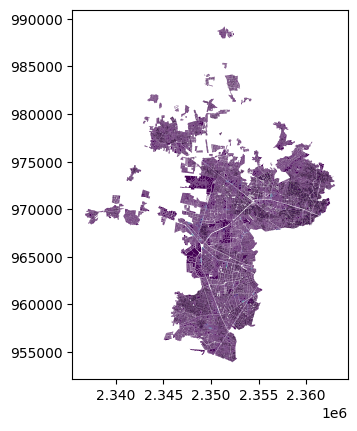

In [17]:
aop_kde.plot('comercio')

Merge data

In [18]:
if 'fid' not in list(aop_kde.columns):
    aop_kde = aop_kde.reset_index().rename(columns={'index':'fid'})

In [19]:
aop_data = aop_data.merge(aop_kde[['fid','cultural_recreativo',
                                  'servicios','comercio','salud',
                                  'educacion','gobierno','industria']])
print(aop_data.shape)
aop_data.head(2)

(682605, 19)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,geometry,pobtot,cultural_recreativo,servicios,comercio,salud,educacion,gobierno,industria
0,0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,"MULTIPOLYGON (((2349152.724 965335.704, 234914...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,"MULTIPOLYGON (((2349168.91 965335.176, 2349157...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculate land use and population percentages

In [20]:
# divide total population by area
aop_area = aop_data[['CVEGEO','area_m2']].groupby('CVEGEO').sum().reset_index().rename(columns={'area_m2':'area_m2_tot'})
aop_data = aop_data.merge(aop_area, on='CVEGEO')
aop_data['pobtot_relative'] = aop_data['pobtot'] * (aop_data['area_m2']/aop_data['area_m2_tot'])
aop_data.head(2)

,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,pobtot,cultural_recreativo,servicios,comercio,salud,educacion,gobierno,industria,area_m2_tot,pobtot_relative
0,0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265377.009117,0.0
1,1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,265377.009117,0.0


In [21]:
aop_data = aop_data.rename(columns={'pobtot_relative':'habitacional',
                                   'educación':'educacion'})

In [22]:
uso_list = ['habitacional','cultural_recreativo','servicios',
           'comercio','salud','educacion','gobierno',
           'industria']

In [23]:
aop_data['uso_tot'] = aop_data[uso_list].sum(axis=1)

In [24]:
for us in uso_list:
    aop_data['pct_'+us] = aop_data[us]/aop_data['uso_tot']

In [25]:
aop_data = aop_data.fillna(0)
aop_data.head(2)

,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,habitacional,uso_tot,pct_habitacional,pct_cultural_recreativo,pct_servicios,pct_comercio,pct_salud,pct_educacion,pct_gobierno,pct_industria
0,0,Sin dato,67.279056,75GRMGQW+89PG,1412000011206018,12.438638,278416.454431,67.279056,0.000242,0.184881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Sin dato,45.355545,75GRMGQW+8CFP,1412000011206018,4.482118,278416.454431,45.355545,0.000163,0.098822,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save data

In [26]:
aop_data.to_file('../../data/processed/prediccion_uso_suelo/complete_model/tess_kde.gpkg')